## Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.9.1


In [3]:
import pathlib
data_dir = pathlib.Path("/Users/edoardomonnetti/Desktop/Magistrale/Reti neurali/Project/chest_xray") 
image_count = len(list(data_dir.glob('*/*/*.jpeg')))
print(image_count)

5856


In [4]:
#from numpy.random import seed
#seed(1)

## Load data

In [5]:
# Create the function to get the images with their label

labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [6]:
# Get the data

train_ds = get_training_data('/Users/edoardomonnetti/Desktop/Magistrale/Reti neurali/Project/chest_xray/train')
test_ds = get_training_data('/Users/edoardomonnetti/Desktop/Magistrale/Reti neurali/Project/chest_xray/test')
val_ds = get_training_data('/Users/edoardomonnetti/Desktop/Magistrale/Reti neurali/Project/chest_xray/val')

OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.6.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



## Data visualization & preprocessing

In [7]:
train_ds.shape

(4416, 2)

<AxesSubplot:ylabel='count'>

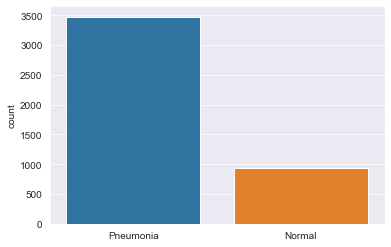

In [8]:
# Count images for each case

l = []
for i in train_ds:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(x=l)

Text(0.5, 1.0, 'NORMAL')

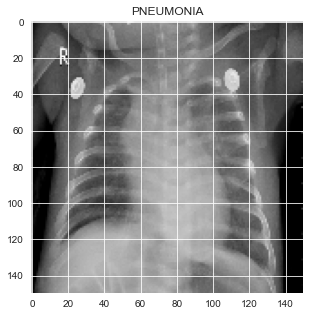

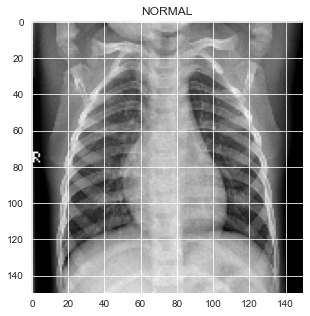

In [9]:
# Preview of two images

plt.figure(figsize = (5,5))
plt.imshow(train_ds[0][0], cmap='gray')
plt.title(labels[train_ds[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train_ds[-1][0], cmap='gray')
plt.title(labels[train_ds[-1][1]])

In [10]:
# Create a list of the (value, label) in form of arrays

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train_ds:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test_ds:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val_ds:
    x_val.append(feature)
    y_val.append(label)

In [11]:
# Normalize the data

x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

In [12]:
x_train.shape

(4416, 150, 150)

In [13]:
# Resize data for deep learning 

x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [14]:
x_train.shape

(4416, 150, 150, 1)

In [15]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.

weight_for_0 = (1 / 942)*(4419)/2.0 
weight_for_1 = (1 / 3476)*(4419)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 2.35
Weight for class 1: 0.64


## Data augmentation

#### In order to avoid overfitting problem, we need to expand artificially our dataset. The idea is to alter the training data with small transformations to reproduce the variations. 

In [16]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
    
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip = False)  # randomly flip images


datagen.fit(x_train)

# For the data augmentation, i choosed to :

# Randomly rotate some training images by 30 degrees
# Randomly Zoom by 20% some training images
# Randomly shift images horizontally by 10% of the width
# Randomly shift images vertically by 10% of the height
# Randomly flip images horizontally. Once our model is ready, we fit the training dataset.

## Model

### CNN

In [17]:
model = Sequential()

model.add(Conv2D(16 , (3,3) , strides = 1, activation = 'relu', 
                 input_shape = (150,150,1)))
model.add(MaxPool2D())

model.add(Conv2D(32 , (3,3) , strides = 1, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())

model.add(Conv2D(16 , (3,3) , strides = 1, activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D())

#model.add(Conv2D(32 , (3,3) , strides = 1, activation = 'relu'))
#model.add(BatchNormalization())
#model.add(MaxPool2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(units = 64 , activation = 'relu',
                activity_regularizer=regularizers.L2(1e-4)
               ))
model.add(Dropout(0.3))

model.add(Dense(units = 1 , activation = 'sigmoid'))

2022-07-08 20:07:08.163824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [39]:
epochs = 50
batch_size = 32

opt = keras.optimizers.Adam()

model.compile(optimizer = opt,
              loss = tf.losses.BinaryCrossentropy(),
              metrics = ['accuracy',
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall')
                        ])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', #learning rate reduction
                                            patience = 2, 
                                            verbose=1,
                                            factor=0.2, 
                                            min_lr=0.000001)


logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)  #savings logs

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15,
                                                     restore_best_weights=True) #early stopping

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 batch_normalization (BatchN  (None, 72, 72, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                        

### Training

In [41]:
hist = model.fit(datagen.flow(x_train,y_train, batch_size = batch_size), 
                epochs = epochs, 
                validation_data = datagen.flow(x_val, y_val),
                callbacks = [tensorboard_callback,learning_rate_reduction, early_stopping_cb],
                class_weight = class_weight
                )

Epoch 1/50
138/138 [==============================] - 65s 451ms/step - loss: 0.2632 - accuracy: 0.8868 - precision: 0.8889 - recall: 0.5356 - val_loss: 0.5567 - val_accuracy: 0.7520 - val_precision: 0.8462 - val_recall: 0.5069 - lr: 0.0010
Epoch 2/50
138/138 [==============================] - 61s 439ms/step - loss: 0.2493 - accuracy: 0.8920 - precision: 0.9203 - recall: 0.5399 - val_loss: 1.8067 - val_accuracy: 0.6279 - val_precision: 1.0000 - val_recall: 0.1221 - lr: 0.0010
Epoch 3/50
138/138 [==============================] - 61s 439ms/step - loss: 0.2547 - accuracy: 0.8972 - precision: 0.9052 - recall: 0.5781 - val_loss: 0.4035 - val_accuracy: 0.8311 - val_precision: 0.7973 - val_recall: 0.8065 - lr: 0.0010
Epoch 4/50
138/138 [==============================] - 61s 438ms/step - loss: 0.2491 - accuracy: 0.8963 - precision: 0.9114 - recall: 0.5685 - val_loss: 11.5121 - val_accuracy: 0.5771 - val_precision: 1.0000 - val_recall: 0.0023 - lr: 0.0010
Epoch 5/50
138/138 [===================

In [42]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")


13/13 [==============================] - 2s 133ms/step - loss: 0.2745 - accuracy: 0.9087 - precision: 0.9126 - recall: 0.9038
Loss of the model is -  0.27445510029792786
13/13 [==============================] - 2s 163ms/step - loss: 0.2745 - accuracy: 0.9087 - precision: 0.9126 - recall: 0.9038
Accuracy of the model is -  90.86538553237915 %


### Analysis

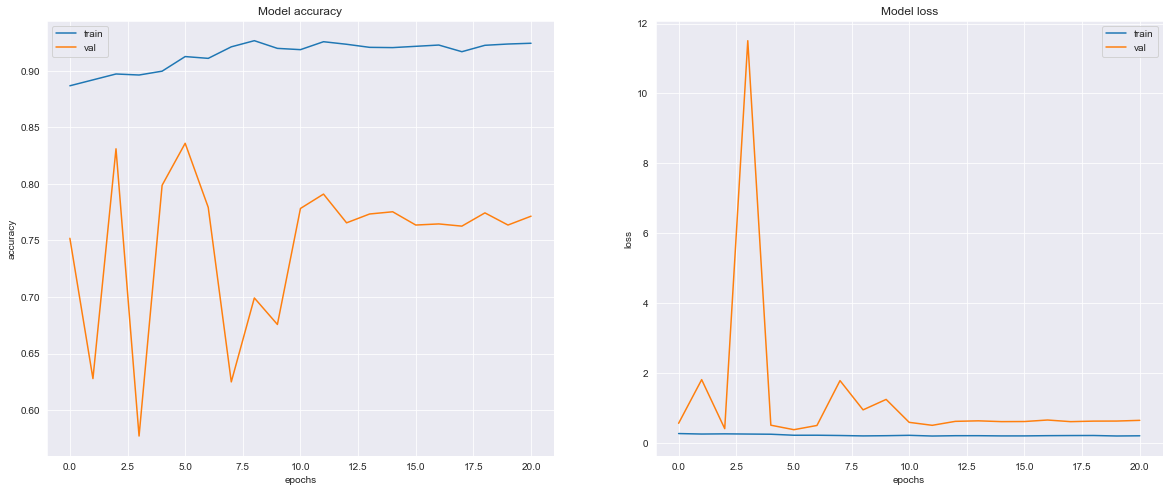

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

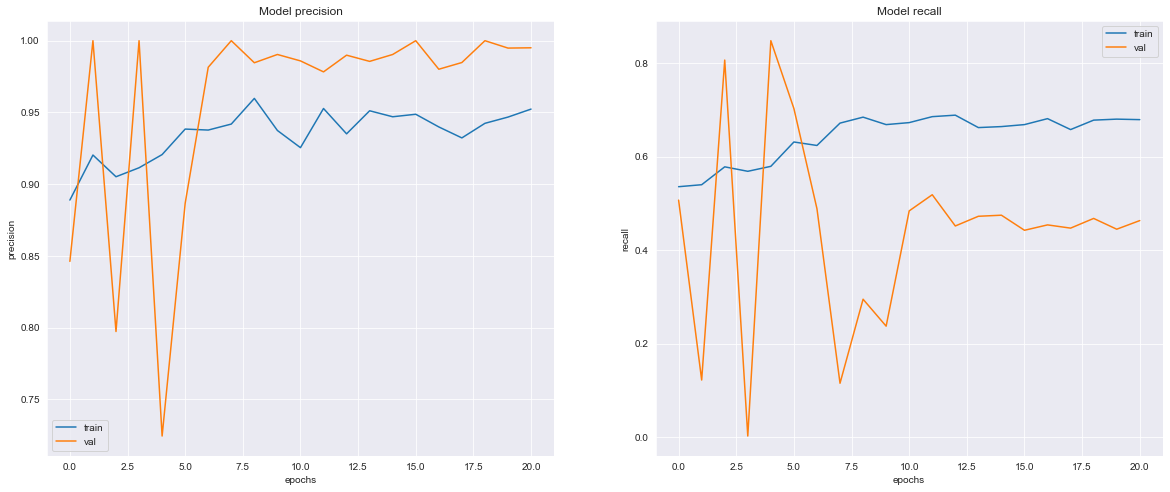

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [45]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]

13/13 [==============================] - 2s 129ms/step


In [46]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.90      0.91      0.91       208
   Normal (Class 1)       0.91      0.90      0.91       208

           accuracy                           0.91       416
          macro avg       0.91      0.91      0.91       416
       weighted avg       0.91      0.91      0.91       416



In [47]:
cm = confusion_matrix(y_test,predictions)
cm

array([[190,  18],
       [ 20, 188]])

<AxesSubplot:>

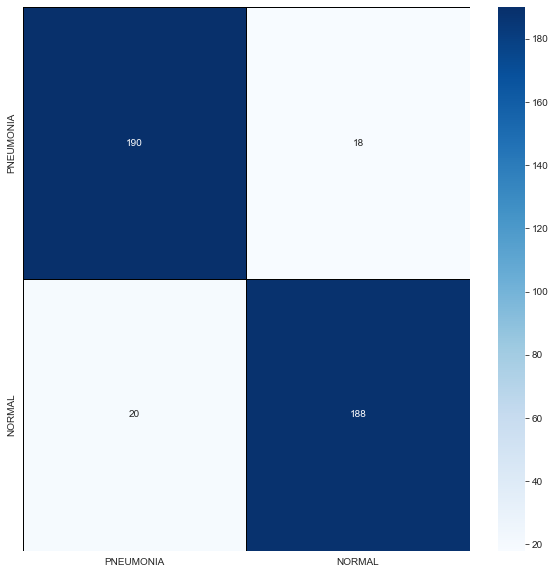

In [48]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy'] 

loss = hist.history['loss']
val_loss = hist.history['val_loss'] 

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
pre = hist.history['precision']
val_pre = hist.history['val_precision'] 

rec = hist.history['recall']
val_rec = hist.history['val_recall'] 

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, pre, label='Training Precision')
plt.plot(epochs_range, val_pre, label='Validation Precision')
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, rec, label='Training Recall')
plt.plot(epochs_range, val_rec, label='Validation Recall')
plt.legend(loc='upper right')
plt.title('Training and Validation Recall')
plt.show()